In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 한글 폰트 설정 (Mac의 경우)
mpl.rc('font', family='AppleGothic')
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 1. 7일 예측

📊 XGBoost 예측 성능 (2025-04-03 ~ 2025-04-09)
RMSE: 467.68
MAE : 373.41
R²  : -1.0393


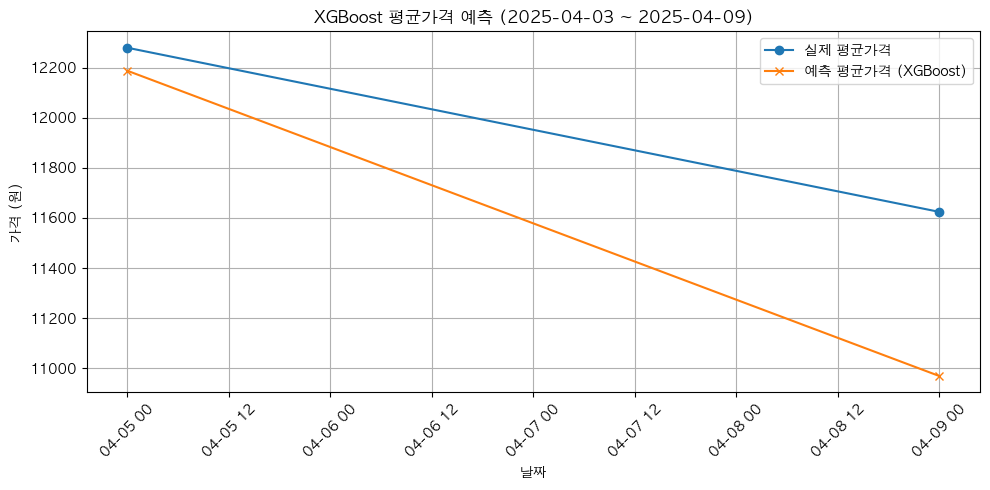

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 및 정리
df = pd.read_csv("cabbage_data/cabbage_final.csv", parse_dates=["DATE"])
df = df.sort_values("DATE")

# 필요없는 컬럼 제거
drop_cols = [
    "전일대비_반입량차이", "전일대비_반입량변화율(%)", "insolation", "wind", "공휴일여부"
]
df = df.drop(columns=drop_cols)

# lag 및 log 변환 추가
df["lag1"] = df["평균가격"].shift(1)
df["lag7"] = df["평균가격"].shift(7)
df["log_평균가격"] = np.log1p(df["평균가격"])
df["log_lag1"] = np.log1p(df["lag1"])
df["log_lag7"] = np.log1p(df["lag7"])

# 2. 피처 설정
feature_cols = [
    "humidity", "precipitation", "temperature", "총반입량",
    "전일대비_가격차이", "전일대비_가격변화율(%)", "일요일여부",
    "log_lag1", "log_lag7"
]
target_col = "log_평균가격"

# 3. 학습/예측 구간 설정
target_start = pd.to_datetime("2025-04-03")
target_end = pd.to_datetime("2025-04-09")

# 결측 제거
df = df.dropna(subset=[target_col] + feature_cols)

# 데이터 분할
train_df = df[df["DATE"] < target_start]
test_df = df[(df["DATE"] >= target_start) & (df["DATE"] <= target_end)]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# 4. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. XGBoost 모델 학습
model = xgb.XGBRegressor(
    n_estimators=50,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    n_jobs=4
)
model.fit(X_train_scaled, y_train)

# 6. 예측 및 복원
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test.values)

# 7. 성능 평가
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("📊 XGBoost 예측 성능 (2025-04-03 ~ 2025-04-09)")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")

# 8. 시각화
test_df = test_df.copy()
test_df["예측값"] = y_pred
test_df["실제값"] = y_true

plt.figure(figsize=(10, 5))
plt.plot(test_df["DATE"], test_df["실제값"], label="실제 평균가격", marker='o')
plt.plot(test_df["DATE"], test_df["예측값"], label="예측 평균가격 (XGBoost)", marker='x')
plt.title("XGBoost 평균가격 예측 (2025-04-03 ~ 2025-04-09)")
plt.xlabel("날짜")
plt.ylabel("가격 (원)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


📊 DLinearPlus (log+lag) 예측 성능
RMSE: 334.33
MAE : 328.21
R2  : 0.9041


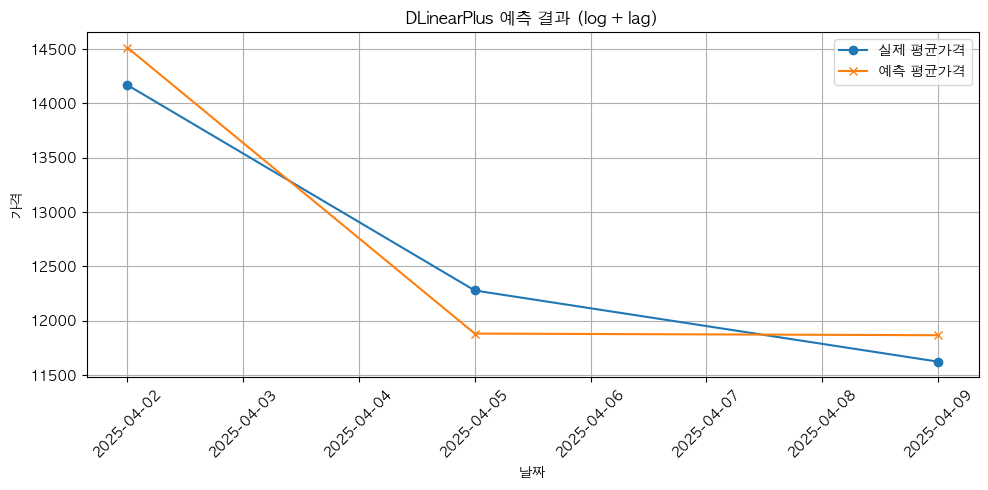

In [11]:
# 0. 필요 라이브러리
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 및 정리
df = pd.read_csv("cabbage_data/cabbage_final.csv", parse_dates=["DATE"])
df = df.sort_values("DATE")

# 필요없는 컬럼 제거
drop_cols = [
    "전일대비_반입량차이", "전일대비_반입량변화율(%)", "insolation", "wind", "공휴일여부"
]
df = df.drop(columns=drop_cols)

# lag 및 log 변환 추가
df["lag1"] = df["평균가격"].shift(1)
df["lag7"] = df["평균가격"].shift(7)
df["log_평균가격"] = np.log1p(df["평균가격"])
df["log_lag1"] = np.log1p(df["lag1"])
df["log_lag7"] = np.log1p(df["lag7"])

# 사용 피처
feature_cols = [
    "humidity", "precipitation", "temperature", "총반입량",
    "전일대비_가격차이", "전일대비_가격변화율(%)", "일요일여부",
    "log_lag1", "log_lag7"
]

# 학습/테스트셋 분할
target_col = "log_평균가격"
target_start = pd.to_datetime("2025-04-02")
target_end = pd.to_datetime("2025-04-09")

df = df.dropna(subset=[target_col] + feature_cols)
train_df = df[df["DATE"] < target_start]
test_df = df[(df["DATE"] >= target_start) & (df["DATE"] <= target_end)]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# 2. 스케일링
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# 3. PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train_scaled, y_train)
test_dataset = TimeSeriesDataset(X_test_scaled, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 4. DLinearPlus 모델 정의
class DLinearPlus(nn.Module):
    def __init__(self, input_dim):
        super(DLinearPlus, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(1)

# 5. 학습
model = DLinearPlus(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

# 6. 예측 및 복원
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    preds_log = model(X_test_tensor).numpy()
    preds = np.expm1(preds_log)  # log1p 복원
    y_true = np.expm1(y_test.values)

# 7. 평가
rmse = np.sqrt(mean_squared_error(y_true, preds))
mae = mean_absolute_error(y_true, preds)
r2 = r2_score(y_true, preds)

print("📊 DLinearPlus (log+lag) 예측 성능")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R2  : {r2:.4f}")

# 8. 시각화
plt.figure(figsize=(10, 5))
plt.plot(test_df["DATE"], y_true, label="실제 평균가격", marker='o')
plt.plot(test_df["DATE"], preds, label="예측 평균가격", marker='x')
plt.title("DLinearPlus 예측 결과 (log + lag)")
plt.xlabel("날짜")
plt.ylabel("가격")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
min_len = min(len(y_pred), len(preds))

y_pred_trim = y_pred[:min_len]
preds_trim = preds[:min_len]
y_true_trim = y_true[:min_len]
dates_trim = test_df["DATE"].values[:min_len]

ensemble_preds = (y_pred_trim + preds_trim) / 2


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_true_trim, ensemble_preds))
mae = mean_absolute_error(y_true_trim, ensemble_preds)
r2 = r2_score(y_true_trim, ensemble_preds)

print("📊 앙상블 예측 성능")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")


📊 앙상블 예측 성능
RMSE: 770.84
MAE : 635.13
R²  : -4.5400


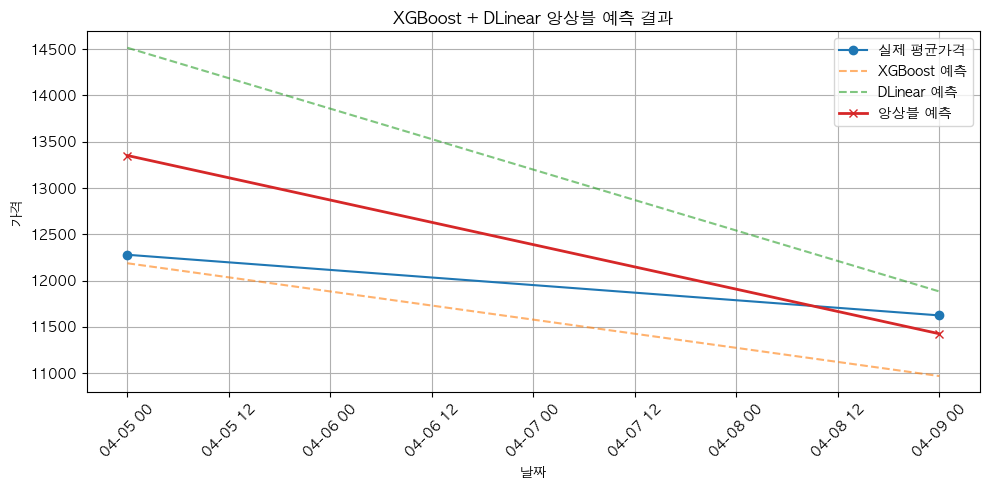

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(dates_trim, y_true_trim, label="실제 평균가격", marker='o')
plt.plot(dates_trim, y_pred_trim, label="XGBoost 예측", linestyle='--', alpha=0.6)
plt.plot(dates_trim, preds_trim, label="DLinear 예측", linestyle='--', alpha=0.6)
plt.plot(dates_trim, ensemble_preds, label="앙상블 예측", marker='x', linewidth=2)
plt.title("XGBoost + DLinear 앙상블 예측 결과")
plt.xlabel("날짜")
plt.ylabel("가격")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 2. 28일 예측

📊 앙상블 예측 성능 (2025-03-10 ~ 2025-04-09)
RMSE: 391.30
MAE : 318.02
R²  : 0.9362


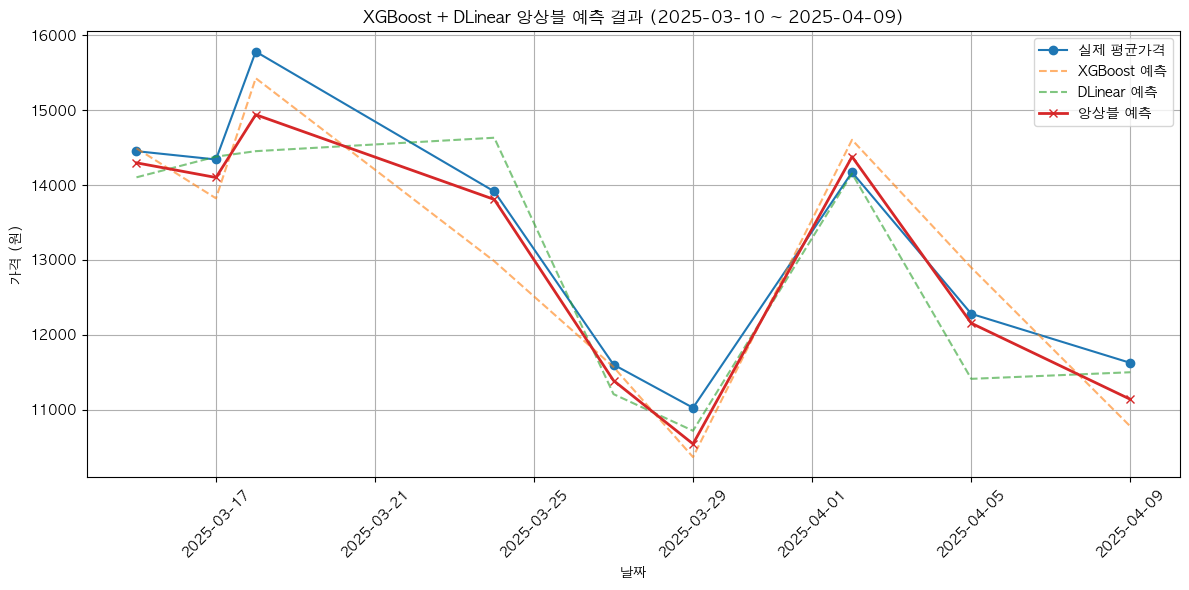

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 1. 데이터 불러오기 및 전처리
df = pd.read_csv("cabbage_data/cabbage_final.csv", parse_dates=["DATE"])
df = df.sort_values("DATE")
drop_cols = ["전일대비_반입량차이", "전일대비_반입량변화율(%)", "insolation", "wind", "공휴일여부"]
df = df.drop(columns=drop_cols)
df["lag1"] = df["평균가격"].shift(1)
df["lag7"] = df["평균가격"].shift(7)
df["log_평균가격"] = np.log1p(df["평균가격"])
df["log_lag1"] = np.log1p(df["lag1"])
df["log_lag7"] = np.log1p(df["lag7"])

feature_cols = [
    "humidity", "precipitation", "temperature", "총반입량",
    "전일대비_가격차이", "전일대비_가격변화율(%)", "일요일여부",
    "log_lag1", "log_lag7"
]
target_col = "log_평균가격"
target_start = pd.to_datetime("2025-03-10")
target_end = pd.to_datetime("2025-04-09")

df = df.dropna(subset=[target_col] + feature_cols)
train_df = df[df["DATE"] < target_start]
test_df = df[(df["DATE"] >= target_start) & (df["DATE"] <= target_end)]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. XGBoost 모델 학습 및 예측
model_xgb = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)
model_xgb.fit(X_train_scaled, y_train)
y_pred_log_xgb = model_xgb.predict(X_test_scaled)
y_pred_xgb = np.expm1(y_pred_log_xgb)

# 3. DLinear 모델 정의 및 학습
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class DLinearPlus(nn.Module):
    def __init__(self, input_dim):
        super(DLinearPlus, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(1)

train_dataset = TimeSeriesDataset(X_train_scaled, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model_dl = DLinearPlus(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_dl.parameters(), lr=0.01)

for epoch in range(100):
    model_dl.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model_dl(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

# 4. DLinear 예측
model_dl.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_pred_log_dl = model_dl(X_test_tensor).numpy()
    y_pred_dl = np.expm1(y_pred_log_dl)

# 5. 앙상블 예측
y_true = np.expm1(y_test.values)
min_len = min(len(y_pred_xgb), len(y_pred_dl), len(y_true))
y_pred_trim = y_pred_xgb[:min_len]
preds_trim = y_pred_dl[:min_len]
y_true_trim = y_true[:min_len]
dates_trim = test_df["DATE"].values[:min_len]

ensemble_preds = (y_pred_trim + preds_trim) / 2

# 6. 평가 지표
rmse = np.sqrt(mean_squared_error(y_true_trim, ensemble_preds))
mae = mean_absolute_error(y_true_trim, ensemble_preds)
r2 = r2_score(y_true_trim, ensemble_preds)

print("📊 앙상블 예측 성능 (2025-03-10 ~ 2025-04-09)")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")

# 7. 시각화
plt.figure(figsize=(12, 6))
plt.plot(dates_trim, y_true_trim, label="실제 평균가격", marker='o')
plt.plot(dates_trim, y_pred_trim, label="XGBoost 예측", linestyle='--', alpha=0.6)
plt.plot(dates_trim, preds_trim, label="DLinear 예측", linestyle='--', alpha=0.6)
plt.plot(dates_trim, ensemble_preds, label="앙상블 예측", marker='x', linewidth=2)
plt.title("XGBoost + DLinear 앙상블 예측 결과 (2025-03-10 ~ 2025-04-09)")
plt.xlabel("날짜")
plt.ylabel("가격 (원)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 3. 60일 예측

📊 XGBoost + DLinear 앙상블 성능 (2025-02-09 ~ 2025-04-09)
RMSE: 370.13
MAE : 283.68
R²  : 0.9600


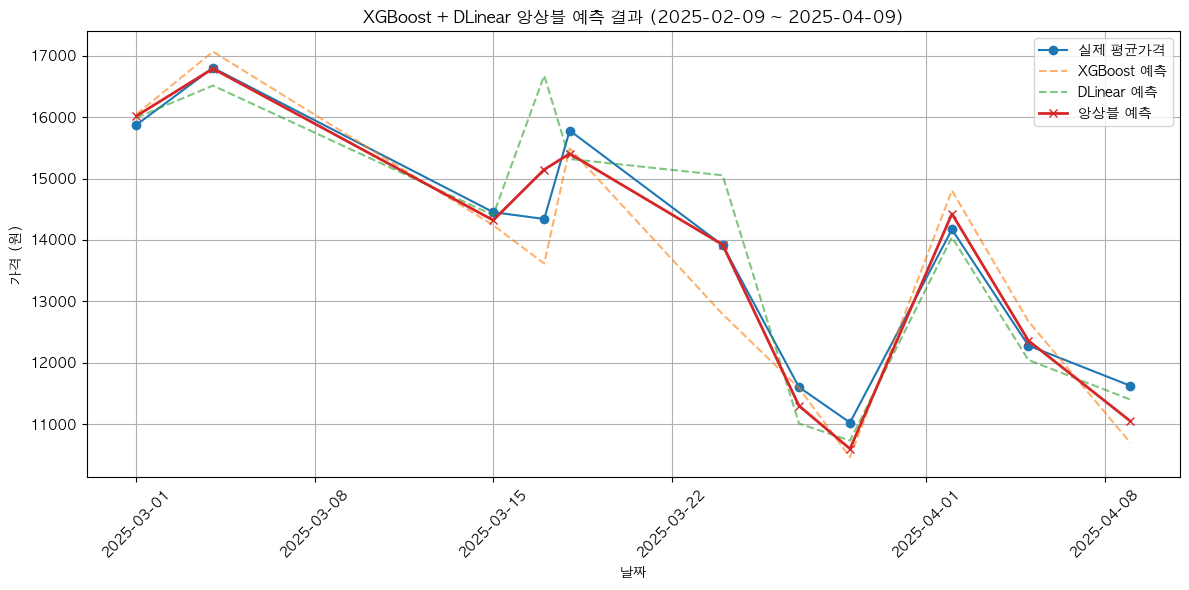

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 1. 데이터 로드 및 전처리
df = pd.read_csv("cabbage_data/cabbage_final.csv", parse_dates=["DATE"])
df = df.sort_values("DATE")
drop_cols = ["전일대비_반입량차이", "전일대비_반입량변화율(%)", "insolation", "wind", "공휴일여부"]
df = df.drop(columns=drop_cols)
df["lag1"] = df["평균가격"].shift(1)
df["lag7"] = df["평균가격"].shift(7)
df["log_평균가격"] = np.log1p(df["평균가격"])
df["log_lag1"] = np.log1p(df["lag1"])
df["log_lag7"] = np.log1p(df["lag7"])

feature_cols = [
    "humidity", "precipitation", "temperature", "총반입량",
    "전일대비_가격차이", "전일대비_가격변화율(%)", "일요일여부",
    "log_lag1", "log_lag7"
]
target_col = "log_평균가격"
target_start = pd.to_datetime("2025-02-09")
target_end = pd.to_datetime("2025-04-09")

df = df.dropna(subset=[target_col] + feature_cols)
train_df = df[df["DATE"] < target_start]
test_df = df[(df["DATE"] >= target_start) & (df["DATE"] <= target_end)]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# 2. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. XGBoost 모델 학습 및 예측
model_xgb = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)
model_xgb.fit(X_train_scaled, y_train)
y_pred_log_xgb = model_xgb.predict(X_test_scaled)
y_pred_xgb = np.expm1(y_pred_log_xgb)

# 4. DLinear 모델 학습 및 예측
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class DLinearPlus(nn.Module):
    def __init__(self, input_dim):
        super(DLinearPlus, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(1)

train_dataset = TimeSeriesDataset(X_train_scaled, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
model_dl = DLinearPlus(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_dl.parameters(), lr=0.01)

for epoch in range(100):
    model_dl.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model_dl(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

model_dl.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_pred_log_dl = model_dl(X_test_tensor).numpy()
    y_pred_dl = np.expm1(y_pred_log_dl)

# 5. 앙상블
y_true = np.expm1(y_test.values)
min_len = min(len(y_pred_xgb), len(y_pred_dl), len(y_true))
y_pred_xgb = y_pred_xgb[:min_len]
y_pred_dl = y_pred_dl[:min_len]
y_true = y_true[:min_len]
dates_trim = test_df["DATE"].values[:min_len]

ensemble_preds = (y_pred_xgb + y_pred_dl) / 2

# 6. 평가
rmse = np.sqrt(mean_squared_error(y_true, ensemble_preds))
mae = mean_absolute_error(y_true, ensemble_preds)
r2 = r2_score(y_true, ensemble_preds)

print("📊 XGBoost + DLinear 앙상블 성능 (2025-02-09 ~ 2025-04-09)")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")

# 7. 시각화
plt.figure(figsize=(12, 6))
plt.plot(dates_trim, y_true, label="실제 평균가격", marker='o')
plt.plot(dates_trim, y_pred_xgb, label="XGBoost 예측", linestyle='--', alpha=0.6)
plt.plot(dates_trim, y_pred_dl, label="DLinear 예측", linestyle='--', alpha=0.6)
plt.plot(dates_trim, ensemble_preds, label="앙상블 예측", marker='x', linewidth=2)
plt.title("XGBoost + DLinear 앙상블 예측 결과 (2025-02-09 ~ 2025-04-09)")
plt.xlabel("날짜")
plt.ylabel("가격 (원)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
